In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
import json
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from lieroy import se3

from recov.datasets import KittiDataset, EthzDataset
from recova.learning.learning import model_from_file
from recova.registration_result_database import RegistrationPairDatabase

from recova.trajectory_evaluation import collect_trajectory_data, make_cumulative_covariances
from recova.util import set_matplotlibrc

np.set_printoptions(precision=3, linewidth=100)

In [21]:
DATABASE_LOCATION = '/home/dlandry/dataset/db_eth_05/'
LOCATION = 'wood_summer'
#POINTCLOUD_DATASET_LOCATION = '/home/dlandry/dataset/kitti/dataset/sequences/{}'.format(LOCATION)
POINTCLOUD_DATASET_LOCATION = '/home/dlandry/dataset/ethz/{}'.format(LOCATION)
LEARNING_DATASET_LOCATION = '/home/dlandry/dataset/learning_sets/2018-08-20-wood.json'
MODEL_LOCATION = '/home/dlandry/dataset/learning_runs/2018-08-21-gazebo-summer.model'


db = RegistrationPairDatabase(DATABASE_LOCATION)
dataset = EthzDataset(pathlib.Path(POINTCLOUD_DATASET_LOCATION))

with open(LEARNING_DATASET_LOCATION) as f:
    learning_dataset = json.load(f)
    
model = model_from_file(MODEL_LOCATION, 'cello')

In [22]:
dataset_indices = {}

ys = np.array(learning_dataset['data']['ys'])

for i, pair in enumerate(learning_dataset['data']['pairs']):
    if pair['dataset'] in dataset_indices:
        dataset_indices[pair['dataset']].append(i)
    else:
        dataset_indices[pair['dataset']] = [i]

dataset_avgs = {}

for x in dataset_indices:
    idx = np.array(dataset_indices[x])
    dataset_avgs[x] = np.mean(ys[idx], axis=0)

In [23]:
dataset = EthzDataset(pathlib.Path(POINTCLOUD_DATASET_LOCATION))

(gt_trajectory, 
 sampled_trajectory,
 cum_covariances, 
 censi_cum_cov) = collect_trajectory_data(db, LOCATION, dataset, learning_dataset['metadata']['descriptor_config'], model)

0
37
100%|██████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 333.21it/s]


In [24]:
def compute_baseline_maha(gt_trajectory, baseline_cov, sampled_trajectory):
    baseline_covariances = np.zeros((len(gt_trajectory), 6, 6))
    for i in range(len(gt_trajectory)):
        baseline_covariances[i] = baseline_cov
    
    cum_covs = make_cumulative_covariances(gt_trajectory, baseline_covariances)
    return compute_mahalanobis_trajectory(gt_trajectory[1:], cum_covs[1:], sampled_trajectory[1:])

In [25]:
dataset_avgs

{'wood_autumn': array([[ 1.933e-03, -5.384e-04, -1.390e-04, -7.478e-06, -1.064e-04,  2.260e-04],
        [-5.384e-04,  1.345e-03,  8.073e-06,  4.841e-05,  7.751e-06, -6.710e-04],
        [-1.390e-04,  8.073e-06,  1.250e-04, -1.650e-05,  5.989e-05, -1.950e-05],
        [-7.478e-06,  4.841e-05, -1.650e-05,  2.316e-05, -7.350e-06,  1.952e-05],
        [-1.064e-04,  7.751e-06,  5.989e-05, -7.350e-06,  4.353e-05, -1.227e-05],
        [ 2.260e-04, -6.710e-04, -1.950e-05,  1.952e-05, -1.227e-05,  6.601e-04]]),
 'wood_summer': array([[ 1.818e-03, -5.140e-04, -1.031e-04, -1.368e-05, -8.802e-05,  1.843e-04],
        [-5.140e-04,  1.305e-03,  1.466e-05,  4.662e-05,  1.254e-05, -6.081e-04],
        [-1.031e-04,  1.466e-05,  9.262e-05, -1.189e-05,  4.485e-05, -2.498e-05],
        [-1.368e-05,  4.662e-05, -1.189e-05,  2.106e-05, -5.387e-06,  1.273e-05],
        [-8.802e-05,  1.254e-05,  4.485e-05, -5.387e-06,  3.404e-05, -1.312e-05],
        [ 1.843e-04, -6.081e-04, -2.498e-05,  1.273e-05, -1.312e-0

In [26]:
def compute_mahalanobis_trajectory(gt_trajectory, cum_cov, trajectory):
    """
    Compute the mahalanobis distance of trajectory w/r to the distributions formed by gt_trajectory and cum_cov
    """
    zped = zip(gt_trajectory, cum_cov, trajectory)
        
    mahalanobis = np.array(list(map(lambda x: mahalanobis_distance(*x), zped))).squeeze()
        
    return mahalanobis

        
def mahalanobis_distance(mean, cov, sample):
    delta = se3.log(np.linalg.inv(mean) @ sample)
    return np.sqrt(delta.reshape((1,-1)) @ (np.linalg.inv(cov) @ delta))

def trajectory_data_to_maha_trajectories(gt_trajectory, sampled_trajectory, cum_covariances, censi_cum_cov, baseline_cov):
    maha_dists = compute_mahalanobis_trajectory(gt_trajectory[1:], cum_covariances[1:], sampled_trajectory[1:])
    censi_maha_dists = compute_mahalanobis_trajectory(gt_trajectory[1:], censi_cum_cov[1:], sampled_trajectory[1:])
    baseline_maha_dists = compute_baseline_maha(gt_trajectory, baseline_cov, sampled_trajectory)
    
    return (maha_dists, censi_maha_dists, baseline_maha_dists)

In [32]:
compute_baseline_maha(gt_trajectory, dataset_avgs['wood_autumn'], sampled_trajectory)
ours, censi, baseline = trajectory_data_to_maha_trajectories(gt_trajectory, sampled_trajectory, cum_covariances, censi_cum_cov, dataset_avgs['wood_autumn'])

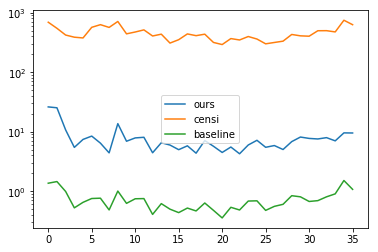

In [33]:
plt.plot(ours, label='ours')
plt.plot(censi, label='censi')
plt.plot(baseline, label='baseline')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
db_kitti = RegistrationPairDatabase('/home/dlandry/dataset/db_kitti_02/')
db_ethz = RegistrationPairDatabase('/home/dlandry/dataset/db_eth_05/')

datasets = [KittiDataset(pathlib.Path('/home/dlandry/dataset/kitti/dataset/sequences/{}'.format(x))) for x in ['02', '05', '10']]
with open(LEARNING_DATASET_LOCATION) as f:
    learning_dataset = json.load(f)
    descriptor_config = learning_dataset['metadata']['descriptor_config']
    
model = model_from_file(MODEL_LOCATION, 'cello')
model_10 = model_from_file('/home/dlandry/dataset/learning_runs/2018-08-20-kitti-05-10.model', 'cello')

collect_data_args = [
    (db_kitti, '02', datasets[0], descriptor_config, model, dataset_avgs['05']),
    (db_kitti, '05', datasets[1], descriptor_config, model, dataset_avgs['10']),
    (db_kitti, '10', datasets[2], descriptor_config, model_10, dataset_avgs['05']),
]

trajectory_data = [(x[1], *collect_trajectory_data(*x[:-1]), x[-1]) for x in collect_data_args]

In [ ]:
def plot_maha_data(location, estimated_maha, censi_maha, baseline_maha, ax):
    ax.plot(estimated_maha, label='Our covariance', color='black')
    #ax.plot(censi_maha, label='Censi covariance', color='black', linestyle='--')
    ax.plot(baseline_maha, label='Baseline')
    #ax.set_yscale('log')
    ax.set_title(location)
    
    ax.set_xlabel('Reading ID')

In [ ]:
maha_data = [trajectory_data_to_maha_trajectories(*x[1:]) for x in trajectory_data]

In [ ]:
maha_data

In [ ]:
set_matplotlibrc()

fig, ax = plt.subplots(1,3, sharey='all')
fig.set_size_inches((7.03, 2.00))
fig.set_dpi(200)

locations = ['Kitti 02', 'Kitti 05', 'Kitti 10']
baseline_covs = [dataset_avgs['05'], dataset_avgs['10'], dataset_avgs['05']]

for i in range(3):
    plot_maha_data(locations[i], *maha_data[i], ax[i])
    
ax[0].set_ylabel('Mahalanobis distance')

plt.legend()
plt.tight_layout()
plt.savefig('/home/dlandry/maha_dists.pdf')
plt.show()

In [ ]:


maha_dists = compute_mahalanobis_trajectory(gt_trajectory[1:], cum_covariances[1:], sampled_trajectory[1:])
censi_maha_dists = compute_mahalanobis_trajectory(gt_trajectory[1:], censi_cum_cov[1:], sampled_trajectory[1:])

In [ ]:
fig, ax = plt.subplots()
ax.plot(maha_dists[:], label='Our covariance')
ax.plot(censi_maha_dists[:], label='Censi covariance')

ax.set_xlabel('Reading ID')
ax.set_ylabel('Mahalanobis distance')
plt.legend()
plt.show()

In [ ]:
np.argmax(maha_dists)

In [ ]:
np.argmax(censi_maha_dists)

In [ ]:
gt_trajectory[1226:1232]

In [ ]:
sampled_trajectory[1226:1232]

In [ ]:
maha_dists[1226:1232]